In [1]:
import matplotlib
import uproot, uproot3
import numpy
import awkward
import numba
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import pandas as pd
from tqdm import trange
import ROOT
import os,sys
from array import array
import pickle

from Lumi import *
from Ratio_Plot import *
from TDR_Style import *

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


Welcome to JupyROOT 6.24/06


In [2]:
uproot.__version__

'4.0.1'

In [3]:
def AddHist_data_AR(file, hist,isbarrel,isData=True, xsec=1, lumi=1):
    
    
    # --read branches special case for MuonEG 2016H
    if 'MuonEG_Run2016H' in file:
        init_branches = [
                    'channel_mark'
                    ,'HLT_Ele27_WPTight_Gsf'
                    ,'HLT_IsoTkMu24'
                    ,'HLT_IsoMu24'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'WZG_photon_sieie'
                    ,'WZG_photon_vidNestedWPBitmap'
                    ,'WZG_photon_eta'
                    ,'WZG_photon_pt'
                    ,'WZG_photon_pfRelIso03_chg'
                    ,'MET']
        
    # --read branches 
    else:
        init_branches =[
                    'channel_mark'
                    ,'HLT_Ele27_WPTight_Gsf'
                    ,'HLT_IsoTkMu24'
                    ,'HLT_IsoMu24'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'WZG_photon_sieie'
                    ,'WZG_photon_vidNestedWPBitmap'
                    ,'WZG_photon_eta'
                    ,'WZG_photon_pt'
                    ,'WZG_photon_pfRelIso03_chg'
                    ,'MET']  
    
    # --Complete branches (data) 
    if isData:
        print('is Data')
 
                
    # --Complete branches (MC)
    else:
        print('is MC')
        add_branches = ['Generator_weight','puWeight','PrefireWeight','Muon_ID_Weight','Electron_ID_Weight','Electron_RECO_Weight']
        met_branches = uproot.open(file+':Events').keys(filter_name='MET_T1Smear*')
        gen_lepton_branches = uproot.open(file+':Events').keys(filter_name='*_lepton*genPartFlav')
        gen_photon_branches= uproot.open(file+':Events').keys(filter_name='*_photon*genPartFlav')
        true_events = uproot.open(file)['nEventsGenWeighted'].values()[0]
        init_branches.extend(add_branches)
        init_branches.extend(gen_lepton_branches)
        init_branches.extend(gen_photon_branches)
        init_branches.extend(met_branches)

                
    # --Prepare main branches
    branches = uproot.open(file+':Events').arrays(init_branches, library='pd')

                
                
    # --Triggers
    
    # Single Electron HLT
    HLT_SingleElectron = branches.loc[:,'HLT_Ele27_WPTight_Gsf'] == True

    # DoubleEG HLT
    HLT_DoubleEG = branches.loc[:,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ'] == True

    # Single MuonHLT
    HLT_SingleMuon1 = branches.loc[:,'HLT_IsoTkMu24'] == True
    HLT_SingleMuon2 = branches.loc[:,'HLT_IsoMu24'] == True
    comb_HLT_SingleMuon  = (HLT_SingleMuon1 | HLT_SingleMuon2)

    # Double Muon HLT
    HLT_DoubleMuon1 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL'] == True
    HLT_DoubleMuon2 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL'] == True
    HLT_DoubleMuon3 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ'] == True
    HLT_DoubleMuon4 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL_DZ'] == True
    if 'DoubleMuon_Run2016H'in file:
        comb_HLT_DoubleMuon = (HLT_DoubleMuon3 | HLT_DoubleMuon4)
    elif 'DoubleMuon_Run2016' in file:
        comb_HLT_DoubleMuon = (HLT_DoubleMuon1 | HLT_DoubleMuon2)
    else:
        comb_HLT_DoubleMuon = (HLT_DoubleMuon1 | HLT_DoubleMuon2) | (HLT_DoubleMuon3 | HLT_DoubleMuon4)

    # MuonEG HLT
    HLT_MuonEG1 = branches.loc[:,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL'] == True
    HLT_MuonEG2 = branches.loc[:,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL'] == True


    if 'MuonEG_Run2016H' in file:
        HLT_MuonEG3 = branches.loc[:,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ'] == True
        HLT_MuonEG4 = branches.loc[:,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL_DZ'] == True
        comb_HLT_MuonEG = (HLT_MuonEG1 | HLT_MuonEG2) | (HLT_MuonEG3 | HLT_MuonEG4)
    else:
        comb_HLT_MuonEG = (HLT_MuonEG1 | HLT_MuonEG2)


    
    # Apply trigger
    if 'SingleMuon' in file:
        print('SingleMuon trigger')
        arrays = branches.loc[comb_HLT_SingleMuon , :].copy()
    elif 'DoubleMuon' in file:
        print('DoubleMuon trigger')
        arrays = branches.loc[~comb_HLT_SingleMuon & comb_HLT_DoubleMuon, :].copy()
    elif 'SingleElectron' in file:
        print('SingleElectron trigger')
        arrays = branches.loc[~comb_HLT_SingleMuon & ~comb_HLT_DoubleMuon &   HLT_SingleElectron ,:].copy()
    elif 'MuonEG' in file:
        print('MuonEG Trigger')
        arrays = branches.loc[~comb_HLT_SingleMuon & ~comb_HLT_DoubleMuon &  ~HLT_SingleElectron & comb_HLT_MuonEG,:].copy()
    elif 'DoubleEG' in file:
        print('DoubleEG trigger')
        arrays = branches.loc[~comb_HLT_SingleMuon & ~comb_HLT_DoubleMuon &  ~HLT_SingleElectron & ~comb_HLT_MuonEG & HLT_DoubleEG,:].copy()
        
    else:
        print('isMC')
        arrays = branches.loc[comb_HLT_SingleMuon | comb_HLT_DoubleMuon | comb_HLT_MuonEG | HLT_SingleElectron |  HLT_DoubleEG ,:].copy()

        
        
    
    # --cuts
    
    # MET 
    if isData:
        MET_cut = (arrays.loc[:,'MET'] > 30)
    else:
        MET_cut = (arrays.loc[:,f'MET_T1Smear_pt'] > 30)
    arrays = arrays.loc[MET_cut,:]
    
    # Photon Eta
    if isbarrel == 1:
        eta_cut = abs(arrays.loc[:,'WZG_photon_eta']) < 1.4442
    elif isbarrel == 0:
        eta_cut = abs((arrays.loc[:,'WZG_photon_eta']) > 1.566) & abs((arrays.loc[:,'WZG_photon_eta']) < 2.5)
    
    mask_mediumID_withoutsieie = (1<<1) | (1<<3) | (1<<5) | (1<<9) | (1<<11) | (1<<13)
    
    # Photon MediumID without sieie
    arrays['mediumID'] = arrays['WZG_photon_vidNestedWPBitmap'] & mask_mediumID_withoutsieie
    arrays = arrays.loc[arrays.loc[:,'mediumID'] == mask_mediumID_withoutsieie, :]
        
    # Photon PT
    pt_cut = (arrays.loc[:,'WZG_photon_pt'] >= 20)
    arrays = arrays.loc[pt_cut & eta_cut ,:]
        
    # -- Fill hist
    
    # data
    if isData:
        for i in trange(0, len(arrays['WZG_photon_pt']), desc=f'fill photonPT for {file}'):
            hist.Fill(float(arrays['WZG_photon_pt'].values[i]))
    # MC
    else:
        arrays['Muon_ID_Weight']       = arrays['Muon_ID_Weight'].apply(lambda x: 1 if x==0 else x)
        arrays['Electron_ID_Weight']   = arrays['Electron_ID_Weight'].apply(lambda x: 1 if x==0 else x)
        arrays['Electron_RECO_Weight'] = arrays['Electron_RECO_Weight'].apply(lambda x: 1 if x==0 else x)
        
        arrays['Generator_weight_sgn'] = arrays['Generator_weight'].apply(lambda x: 1 if x >= 0 else -1)
        arrays['true_weight'] = lumi * xsec * 1000 *  arrays['PrefireWeight'] * arrays['puWeight']\
        * arrays['Muon_ID_Weight'] * arrays['Electron_ID_Weight'] * arrays['Electron_RECO_Weight'] *  arrays['Generator_weight_sgn'] / true_events   

        for i in trange(len(arrays['WZG_photon_pt']), desc=f'fill photonPT for {file}'):
            hist.Fill(float(arrays['WZG_photon_pt'].values[i]),float(arrays['true_weight'].values[i]))
    
def AddHist_dataFake_AR(file, hist,isbarrel,isData=True,xsec=1,lumi=1):
    
    # --read branches special case for MuonEG 2016H
    if 'MuonEG_Run2016H' in file:
        init_branches = [
                    'channel_mark'
                    ,'HLT_Ele27_WPTight_Gsf'
                    ,'HLT_IsoTkMu24'
                    ,'HLT_IsoMu24'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'WZG_photon_sieie'
                    ,'WZG_photon_vidNestedWPBitmap'
                    ,'WZG_photon_eta'
                    ,'WZG_photon_pt'
                    ,'WZG_photon_pfRelIso03_chg'
                    ,'MET']
        
    # --read branches 
    else:
        init_branches = [
                    'channel_mark'
                    ,'HLT_Ele27_WPTight_Gsf'
                    ,'HLT_IsoTkMu24'
                    ,'HLT_IsoMu24'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL'
                    ,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL_DZ'
                    ,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL'
                    ,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ'
                    ,'WZG_photon_sieie'
                    ,'WZG_photon_vidNestedWPBitmap'
                    ,'WZG_photon_eta'
                    ,'WZG_photon_pt'
                    ,'WZG_photon_pfRelIso03_chg'
                    ,'MET'] 
    
    # --Complete branches (data) 
    if isData:
        print('is Data')

                
    # --Complete branches (MC)
    else:
        print('is MC')
        add_branches = ['Generator_weight','puWeight','PrefireWeight','Muon_ID_Weight','Electron_ID_Weight','Electron_RECO_Weight']
        met_branches = uproot.open(file+':Events').keys(filter_name='MET_T1Smear*')
        gen_lepton_branches = uproot.open(file+':Events').keys(filter_name='*_lepton*genPartFlav')
        gen_photon_branches= uproot.open(file+':Events').keys(filter_name='*_photon*genPartFlav')
        true_events = uproot.open(file)['nEventsGenWeighted'].values()[0]
        init_branches.extend(add_branches)
        init_branches.extend(gen_lepton_branches)
        init_branches.extend(gen_photon_branches)
        init_branches.extend(met_branches)

                
    # --Prepare main branches
    branches = uproot.open(file+':Events').arrays(init_branches, library='pd')
    
    # --Triggers
    
    # Single Electron HLT
    HLT_SingleElectron = branches.loc[:,'HLT_Ele27_WPTight_Gsf'] == True

    # DoubleEG HLT
    HLT_DoubleEG = branches.loc[:,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ'] == True

    # Single MuonHLT
    HLT_SingleMuon1 = branches.loc[:,'HLT_IsoTkMu24'] == True
    HLT_SingleMuon2 = branches.loc[:,'HLT_IsoMu24'] == True
    comb_HLT_SingleMuon  = (HLT_SingleMuon1 | HLT_SingleMuon2)

    # Double Muon HLT
    HLT_DoubleMuon1 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL'] == True
    HLT_DoubleMuon2 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL'] == True
    HLT_DoubleMuon3 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ'] == True
    HLT_DoubleMuon4 = branches.loc[:,'HLT_Mu17_TrkIsoVVL_TkMu8_TrkIsoVVL_DZ'] == True
    if 'DoubleMuon_Run2016H'in file:
        comb_HLT_DoubleMuon = (HLT_DoubleMuon3 | HLT_DoubleMuon4)
    elif 'DoubleMuon_Run2016' in file:
        comb_HLT_DoubleMuon = (HLT_DoubleMuon1 | HLT_DoubleMuon2)
    else:
        comb_HLT_DoubleMuon = (HLT_DoubleMuon1 | HLT_DoubleMuon2) | (HLT_DoubleMuon3 | HLT_DoubleMuon4)

    # MuonEG HLT
    HLT_MuonEG1 = branches.loc[:,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL'] == True
    HLT_MuonEG2 = branches.loc[:,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL'] == True


    if 'MuonEG_Run2016H' in file:
        HLT_MuonEG3 = branches.loc[:,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ'] == True
        HLT_MuonEG4 = branches.loc[:,'HLT_Mu23_TrkIsoVVL_Ele8_CaloIdL_TrackIdL_IsoVL_DZ'] == True
        comb_HLT_MuonEG = (HLT_MuonEG1 | HLT_MuonEG2) | (HLT_MuonEG3 | HLT_MuonEG4)
    else:
        comb_HLT_MuonEG = (HLT_MuonEG1 | HLT_MuonEG2)


    
    # Apply trigger
    if 'SingleMuon' in file:
        print('SingleMuon trigger')
        arrays = branches.loc[comb_HLT_SingleMuon , :].copy()
    elif 'DoubleMuon' in file:
        print('DoubleMuon trigger')
        arrays = branches.loc[~comb_HLT_SingleMuon & comb_HLT_DoubleMuon, :].copy()
    elif 'SingleElectron' in file:
        print('SingleElectron trigger')
        arrays = branches.loc[~comb_HLT_SingleMuon & ~comb_HLT_DoubleMuon &   HLT_SingleElectron ,:].copy()
    elif 'MuonEG' in file:
        print('MuonEG Trigger')
        arrays = branches.loc[~comb_HLT_SingleMuon & ~comb_HLT_DoubleMuon &  ~HLT_SingleElectron & comb_HLT_MuonEG,:].copy()
    elif 'DoubleEG' in file:
        print('DoubleEG trigger')
        arrays = branches.loc[~comb_HLT_SingleMuon & ~comb_HLT_DoubleMuon &  ~HLT_SingleElectron & ~comb_HLT_MuonEG & HLT_DoubleEG,:].copy()
        
    else:
        print('isMC')
        arrays = branches.loc[comb_HLT_SingleMuon | comb_HLT_DoubleMuon | comb_HLT_MuonEG | HLT_SingleElectron |  HLT_DoubleEG ,:].copy()

    
    # --cuts
    # MET 
    if isData:
        MET_cut = (arrays.loc[:,'MET'] > 30)
    else:
        MET_cut = (arrays.loc[:,f'MET_T1Smear_pt'] > 30)
    arrays = arrays.loc[MET_cut,:]
        
    # Photon Eta
    if isbarrel == 1:
        eta_cut = abs(arrays.loc[:,'WZG_photon_eta']) < 1.4442
    elif isbarrel == 0:
        eta_cut = abs((arrays.loc[:,'WZG_photon_eta']) > 1.566) & abs((arrays.loc[:,'WZG_photon_eta']) < 2.5)

    # need invert sieie? ( and of course, invert IsoChg)
    # Photon MediumID with inveted sieie and without IsoChg
    #mask_mediumID_withoutsieie_andIsoChg = (1<<1) | (1<<3) | (1<<5) | (1<<11) | (1<<13)
    #mask_full_mediumID = (1<<1) | (1<<3) | (1<<5) | (1<<7) | (1<<9) | (1<<11) | (1<<13)
    #arrays['mediumID'] = arrays['WZG_photon_vidNestedWPBitmap'] & mask_full_mediumID
    #arrays = arrays.loc[arrays.loc[:,'mediumID'] == mask_mediumID_withoutsieie_andIsoChg,:]
        
        
    # Photon IsoChg SB cut
    sb = [4,10]

    chg_cut = ((arrays.loc[:,"WZG_photon_pfRelIso03_chg"]*arrays.loc[:,"WZG_photon_pt"]) > sb[0]) & ((arrays.loc[:,"WZG_photon_pfRelIso03_chg"]*arrays.loc[:,"WZG_photon_pt"]) < sb[1])
    pt_cut  = (arrays.loc[:,'WZG_photon_pt'] >= 20)        
    
    arrays = arrays.loc[pt_cut & eta_cut & chg_cut,:]
    
    
    # -- Fill hist
    # data
    if isData:
        for i in trange(0, len(arrays['WZG_photon_pt']), desc=f'fill photonPT for {file}'):
            hist.Fill(float(arrays['WZG_photon_pt'].values[i]))
    # MC
    else:
        arrays['Muon_ID_Weight']       = arrays['Muon_ID_Weight'].apply(lambda x: 1 if x==0 else x)
        arrays['Electron_ID_Weight']   = arrays['Electron_ID_Weight'].apply(lambda x: 1 if x==0 else x)
        arrays['Electron_RECO_Weight'] = arrays['Electron_RECO_Weight'].apply(lambda x: 1 if x==0 else x)
        
        arrays['Generator_weight_sgn'] = arrays['Generator_weight'].apply(lambda x: 1 if x >= 0 else -1)
        arrays['true_weight'] = lumi * xsec * 1000 *  arrays['PrefireWeight'] * arrays['puWeight']\
        * arrays['Muon_ID_Weight'] * arrays['Electron_ID_Weight'] * arrays['Electron_RECO_Weight'] *  arrays['Generator_weight_sgn'] / true_events   

        for i in trange(len(arrays['WZG_photon_pt']), desc=f'fill photonPT for {file}'):
            hist.Fill(float(arrays['WZG_photon_pt'].values[i]),float(arrays['true_weight'].values[i]))

In [4]:
## 2016 AR

filelist_data = [
"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleEG_Run2016B.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleEG_Run2016C.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleEG_Run2016D.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleEG_Run2016E.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleEG_Run2016F.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleEG_Run2016G.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleEG_Run2016H.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleMuon_Run2016B.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleMuon_Run2016C.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleMuon_Run2016D.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleMuon_Run2016E.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleMuon_Run2016F.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleMuon_Run2016G.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleMuon_Run2016H.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/MuonEG_Run2016B.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/MuonEG_Run2016C.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/MuonEG_Run2016D.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/MuonEG_Run2016E.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/MuonEG_Run2016F.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/MuonEG_Run2016G.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/MuonEG_Run2016H.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleElectron_Run2016B.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleElectron_Run2016C.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleElectron_Run2016D.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleElectron_Run2016E.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleElectron_Run2016F.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleElectron_Run2016G.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleElectron_Run2016H.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleMuon_Run2016B.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleMuon_Run2016C.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleMuon_Run2016D.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleMuon_Run2016E.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleMuon_Run2016F.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleMuon_Run2016G.root"
,"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleMuon_Run2016H.root"
]

In [5]:
filelist_MC = {
    
   "TTG":
        {"name":"TTGJets",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_2016.root",
        "xsec":4.078,
        },
   "TTZ":
        {"name":"TTZToLLNuNu",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/TTZToLLNuNu_M-10_TuneCP5_13TeV-amcatnlo-pythia8_2016.root",
        "xsec":0.2432,
        },
   "TTW":
        {"name":"TTWJetsToLNu",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_2016.root",
        "xsec":0.2149,
        },
   "tZq":
        {"name":"tZq_ll",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/tZq_ll_4f_ckm_NLO_TuneCP5_13TeV-amcatnlo-pythia8_2016.root",
        "xsec":0.07358,
        },
   "WWW":
        {"name":"WWW",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/WWW_4F_TuneCP5_13TeV-amcatnlo-pythia8_2016.root",
        "xsec":0.2086,
        },
   "ZGToLLG":
        {"name":"ZGToLLG",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/ZGToLLG_01J_5f_TuneCP5_13TeV-amcatnloFXFX-pythia8_2016.root",
        "xsec":55.48,
        },
    "ZZ":
        {"name":"ZZ",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/ZZ_TuneCP5_13TeV-pythia8_2016.root",
        "xsec":16.523, # NLO
        },
    "WZG":
        {"name":"WZG",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/wza_2016.root",
        "xsec":0.0384,
        },
   "WWZ":
        {"name":"WWZ",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/WWZ_4F_TuneCP5_13TeV-amcatnlo-pythia8_2016.root",
        "xsec":0.1707,
        },
   "ggZZ_2e2mu":
        {"name":"ggZZ2e2mu",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/GluGluToContinToZZTo2e2mu_TuneCP5_13TeV-mcfm701-pythia8_2016.root",
        "xsec":0.00319,
        },
#   "ggZZ_2e2nu":
#        {"name":"ggZZ2e2nu",
#        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/2017/GluGluToContinToZZTo2e2nu_TuneCP5_13TeV-mcfm701-pythia8_2017_0000.root",
#        "xsec":0.00319,
#        },
   "ggZZ_2e2tau":
        {"name":"ggZZ2e2tau",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/GluGluToContinToZZTo2e2tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root",
        "xsec":0.00319,
        },
#   "ggZZ_2mu2nu":
#        {"name":"ggZZ2mu2nu",
#        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/2017/GluGluToContinToZZTo2mu2nu_TuneCP5_13TeV-mcfm701-pythia8_2017_0000.root",
#        "xsec":0.00319,
#        },
   "ggZZ_2mu2tau":
        {"name":"ggZZ2mu2tau",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/GluGluToContinToZZTo2mu2tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root",
        "xsec":0.00319,
        },
   "ggZZ_4e":
        {"name":"ggZZ4e",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/GluGluToContinToZZTo4e_TuneCP5_13TeV-mcfm701-pythia8_2016.root",
        "xsec":0.00159,
        },
   "ggZZ_4mu":
        {"name":"ggZZ4mu",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/GluGluToContinToZZTo4mu_TuneCP5_13TeV-mcfm701-pythia8_2016.root",
        "xsec":0.00159,
        },
   "ggZZ_4tau":
        {"name":"ggZZ4tau",
        "path":"/eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/GluGluToContinToZZTo4tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root",
        "xsec":0.00159,
        }    
}

In [21]:
from array import array



# Origin
xbins_EB = [20,30,50,80,120,180]
xbins_EE = [20,50,180]

# Tunning
#xbins_EB = [20,35,400]
#xbins_EE = [20,400]



isbarrel = 1 # barrel
#isbarrel = 0 # endcap


nbins=-1
if isbarrel == 1:
    xbins = xbins_EB
    nbins = len(xbins_EB) - 1
elif isbarrel ==0:
    xbins = xbins_EE
    nbins = len(xbins_EE) - 1
else:
    print("wrong!")
    

# --Fake template
hist_datafake = ROOT.TH1F("","",nbins,array('d',xbins))
hist_datafake.Sumw2()
# data
for file in filelist_data:
    AddHist_dataFake_AR(file, hist_datafake,isbarrel,True)
# MC
for file in filelist_MC:
    AddHist_dataFake_AR(filelist_MC[file]['path'], hist_datafake,isbarrel,False,filelist_MC[file]['xsec'],35.86)
    
    
# Data template
hist_data = ROOT.TH1F("","",nbins,array('d',xbins))
hist_data.Sumw2()
# data
for file in filelist_data:
    AddHist_data_AR(file, hist_data, isbarrel)   
# MC
for file in filelist_MC:
    AddHist_data_AR(filelist_MC[file]['path'], hist_data,isbarrel,False,filelist_MC[file]['xsec'],35.86)                    



is Data
DoubleEG trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleEG_Run2016B.root: 0it [00:00, ?it/s]

is Data


DoubleEG trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleEG_Run2016C.root: 0it [00:00, ?it/s]

is Data


DoubleEG trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleEG_Run2016D.root: 0it [00:00, ?it/s]

is Data


DoubleEG trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleEG_Run2016E.root: 0it [00:00, ?it/s]

is Data


DoubleEG trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleEG_Run2016F.root: 0it [00:00, ?it/s]

is Data


DoubleEG trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleEG_Run2016G.root: 0it [00:00, ?it/s]

is Data


DoubleEG trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleEG_Run2016H.root: 0it [00:00, ?it/s]

is Data


DoubleMuon trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleMuon_Run2016B.root: 0it [00:00, ?it/s]

is Data


DoubleMuon trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleMuon_Run2016C.root: 0it [00:00, ?it/s]

is Data


DoubleMuon trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleMuon_Run2016D.root: 0it [00:00, ?it/s]

is Data


DoubleMuon trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleMuon_Run2016E.root: 0it [00:00, ?it/s]

is Data


DoubleMuon trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleMuon_Run2016F.root: 0it [00:00, ?it/s]

is Data


DoubleMuon trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleMuon_Run2016G.root: 0it [00:00, ?it/s]

is Data


DoubleMuon trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleMuon_Run2016H.root: 0it [00:00, ?it/s]

is Data


MuonEG Trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/MuonEG_Run2016B.root: 0it [00:00, ?it/s]

is Data


MuonEG Trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/MuonEG_Run2016C.root: 0it [00:00, ?it/s]

is Data


MuonEG Trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/MuonEG_Run2016D.root: 0it [00:00, ?it/s]

is Data


MuonEG Trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/MuonEG_Run2016E.root: 0it [00:00, ?it/s]

is Data


MuonEG Trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/MuonEG_Run2016F.root: 0it [00:00, ?it/s]

is Data


MuonEG Trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/MuonEG_Run2016G.root: 0it [00:00, ?it/s]

is Data


MuonEG Trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/MuonEG_Run2016H.root: 0it [00:00, ?it/s]

is Data


SingleElectron trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleElectron_Run2016B.root: 0it [00:00, ?it/s]

is Data


SingleElectron trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleElectron_Run2016C.root: 0it [00:00, ?it/s]

is Data


SingleElectron trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleElectron_Run2016D.root: 0it [00:00, ?it/s]

is Data


SingleElectron trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleElectron_Run2016E.root: 100%|██████████| 1/1 [00:00<00:00, 8019.70it/s]

is Data


SingleElectron trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleElectron_Run2016F.root: 0it [00:00, ?it/s]

is Data


SingleElectron trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleElectron_Run2016G.root: 0it [00:00, ?it/s]

is Data


SingleElectron trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleElectron_Run2016H.root: 0it [00:00, ?it/s]

is Data


SingleMuon trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleMuon_Run2016B.root: 0it [00:00, ?it/s]

is Data


SingleMuon trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleMuon_Run2016C.root: 100%|██████████| 3/3 [00:00<00:00, 21326.97it/s]

is Data


SingleMuon trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleMuon_Run2016D.root: 0it [00:00, ?it/s]

is Data


SingleMuon trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleMuon_Run2016E.root: 0it [00:00, ?it/s]

is Data


SingleMuon trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleMuon_Run2016F.root: 0it [00:00, ?it/s]

is Data


SingleMuon trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleMuon_Run2016G.root: 100%|██████████| 5/5 [00:00<00:00, 34663.67it/s]

is Data


SingleMuon trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleMuon_Run2016H.root: 0it [00:00, ?it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_2016.root: 100%|██████████| 1/1 [00:00<00:00, 5108.77it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/TTZToLLNuNu_M-10_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 100%|██████████| 1452/1452 [00:00<00:00, 117665.47it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_2016.root: 100%|██████████| 46/46 [00:00<00:00, 72451.36it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/tZq_ll_4f_ckm_NLO_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 100%|██████████| 585/585 [00:00<00:00, 114320.82it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/WWW_4F_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 0it [00:00, ?it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/ZGToLLG_01J_5f_TuneCP5_13TeV-amcatnloFXFX-pythia8_2016.root: 100%|██████████| 28/28 [00:00<00:00, 61262.66it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/ZZ_TuneCP5_13TeV-pythia8_2016.root: 100%|██████████| 3/3 [00:00<00:00, 14926.35it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/wza_2016.root: 100%|██████████| 28/28 [00:00<00:00, 65064.00it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/WWZ_4F_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 100%|██████████| 3/3 [00:00<00:00, 8450.58it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/GluGluToContinToZZTo2e2mu_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 176/176 [00:00<00:00, 102670.03it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/GluGluToContinToZZTo2e2tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 304/304 [00:00<00:00, 105525.81it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/GluGluToContinToZZTo2mu2tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 433/433 [00:00<00:00, 119427.48it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/GluGluToContinToZZTo4e_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 259/259 [00:00<00:00, 105447.95it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/GluGluToContinToZZTo4mu_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 186/186 [00:00<00:00, 98515.03it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/GluGluToContinToZZTo4tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 1/1 [00:00<00:00, 3953.16it/s]

is Data


DoubleEG trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleEG_Run2016B.root: 0it [00:00, ?it/s]

is Data


DoubleEG trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleEG_Run2016C.root: 0it [00:00, ?it/s]

is Data


DoubleEG trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleEG_Run2016D.root: 0it [00:00, ?it/s]

is Data


DoubleEG trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleEG_Run2016E.root: 0it [00:00, ?it/s]

is Data


DoubleEG trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleEG_Run2016F.root: 0it [00:00, ?it/s]

is Data


DoubleEG trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleEG_Run2016G.root: 0it [00:00, ?it/s]

is Data


DoubleEG trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleEG_Run2016H.root: 0it [00:00, ?it/s]

is Data


DoubleMuon trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleMuon_Run2016B.root: 0it [00:00, ?it/s]

is Data


DoubleMuon trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleMuon_Run2016C.root: 0it [00:00, ?it/s]

is Data


DoubleMuon trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleMuon_Run2016D.root: 0it [00:00, ?it/s]

is Data


DoubleMuon trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleMuon_Run2016E.root: 0it [00:00, ?it/s]

is Data


DoubleMuon trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleMuon_Run2016F.root: 0it [00:00, ?it/s]

is Data


DoubleMuon trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleMuon_Run2016G.root: 0it [00:00, ?it/s]

is Data


DoubleMuon trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/DoubleMuon_Run2016H.root: 0it [00:00, ?it/s]

is Data


MuonEG Trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/MuonEG_Run2016B.root: 0it [00:00, ?it/s]

is Data


MuonEG Trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/MuonEG_Run2016C.root: 0it [00:00, ?it/s]

is Data


MuonEG Trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/MuonEG_Run2016D.root: 0it [00:00, ?it/s]

is Data


MuonEG Trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/MuonEG_Run2016E.root: 0it [00:00, ?it/s]

is Data


MuonEG Trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/MuonEG_Run2016F.root: 0it [00:00, ?it/s]

is Data


MuonEG Trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/MuonEG_Run2016G.root: 0it [00:00, ?it/s]

is Data


MuonEG Trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/MuonEG_Run2016H.root: 0it [00:00, ?it/s]

is Data


SingleElectron trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleElectron_Run2016B.root: 0it [00:00, ?it/s]

is Data


SingleElectron trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleElectron_Run2016C.root: 0it [00:00, ?it/s]

is Data


SingleElectron trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleElectron_Run2016D.root: 100%|██████████| 1/1 [00:00<00:00, 6096.37it/s]

is Data


SingleElectron trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleElectron_Run2016E.root: 100%|██████████| 1/1 [00:00<00:00, 7307.15it/s]

is Data


SingleElectron trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleElectron_Run2016F.root: 0it [00:00, ?it/s]

is Data


SingleElectron trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleElectron_Run2016G.root: 100%|██████████| 2/2 [00:00<00:00, 20262.34it/s]

is Data


SingleElectron trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleElectron_Run2016H.root: 100%|██████████| 1/1 [00:00<00:00, 10356.31it/s]

is Data


SingleMuon trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleMuon_Run2016B.root: 100%|██████████| 5/5 [00:00<00:00, 40721.40it/s]

is Data


SingleMuon trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleMuon_Run2016C.root: 100%|██████████| 4/4 [00:00<00:00, 14860.24it/s]

is Data


SingleMuon trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleMuon_Run2016D.root: 100%|██████████| 2/2 [00:00<00:00, 16100.98it/s]

is Data


SingleMuon trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleMuon_Run2016E.root: 100%|██████████| 3/3 [00:00<00:00, 9884.46it/s]

is Data


SingleMuon trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleMuon_Run2016F.root: 100%|██████████| 1/1 [00:00<00:00, 9341.43it/s]

is Data


SingleMuon trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleMuon_Run2016G.root: 100%|██████████| 4/4 [00:00<00:00, 16209.87it/s]

is Data


SingleMuon trigger


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/SingleMuon_Run2016H.root: 100%|██████████| 7/7 [00:00<00:00, 25420.02it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/TTGJets_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_2016.root: 100%|██████████| 9/9 [00:00<00:00, 28339.89it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/TTZToLLNuNu_M-10_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 100%|██████████| 2173/2173 [00:00<00:00, 69054.99it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_2016.root: 100%|██████████| 77/77 [00:00<00:00, 89636.80it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/tZq_ll_4f_ckm_NLO_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 100%|██████████| 901/901 [00:00<00:00, 113868.50it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/WWW_4F_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 0it [00:00, ?it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/ZGToLLG_01J_5f_TuneCP5_13TeV-amcatnloFXFX-pythia8_2016.root: 100%|██████████| 89/89 [00:00<00:00, 98157.52it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/ZZ_TuneCP5_13TeV-pythia8_2016.root: 100%|██████████| 22/22 [00:00<00:00, 54407.25it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/wza_2016.root: 100%|██████████| 1125/1125 [00:00<00:00, 113163.82it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/WWZ_4F_TuneCP5_13TeV-amcatnlo-pythia8_2016.root: 100%|██████████| 13/13 [00:00<00:00, 31318.75it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/GluGluToContinToZZTo2e2mu_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 3773/3773 [00:00<00:00, 100565.64it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/GluGluToContinToZZTo2e2tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 447/447 [00:00<00:00, 117273.65it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/GluGluToContinToZZTo2mu2tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 520/520 [00:00<00:00, 85213.44it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/GluGluToContinToZZTo4e_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 8660/8660 [00:00<00:00, 126198.83it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/GluGluToContinToZZTo4mu_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 3947/3947 [00:00<00:00, 125865.15it/s]

is MC


isMC


fill photonPT for /eos/home-j/jiwoong/WZG_DB/2016/pre_post_separated_220209/FakePhoton/AR/merged/GluGluToContinToZZTo4tau_TuneCP5_13TeV-mcfm701-pythia8_2016.root: 100%|██████████| 7/7 [00:00<00:00, 29507.67it/s]


35.86 fb^{-1} (13 TeV)


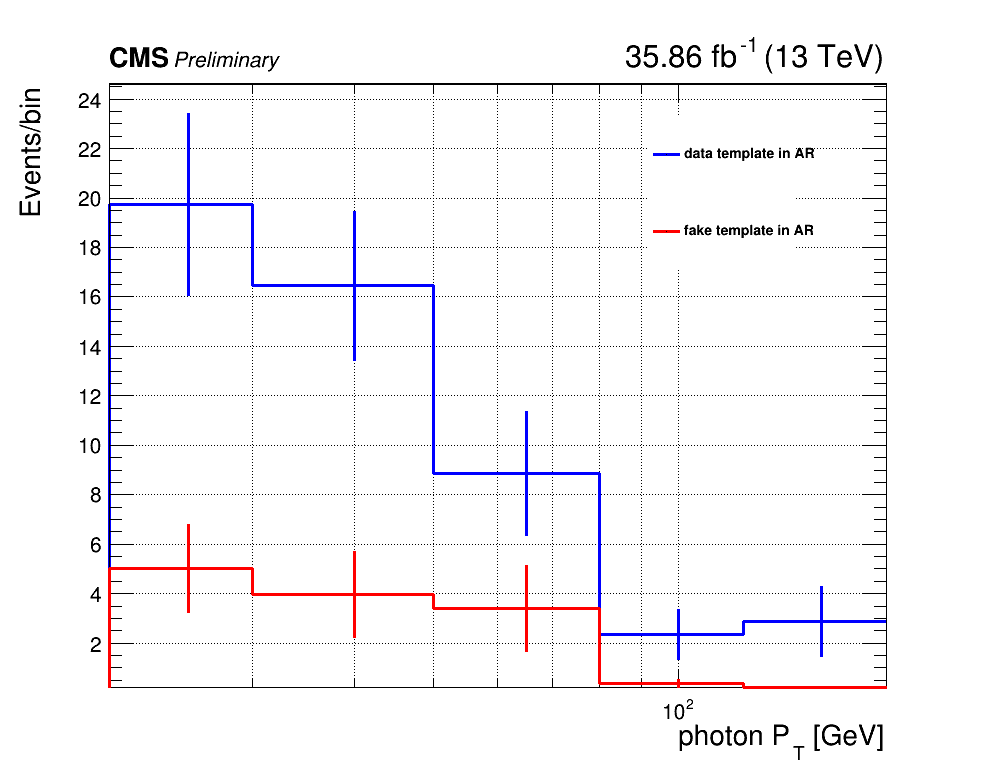

In [22]:
c1 = ROOT.TCanvas("","",1000,800)
c1.Draw()

hist_data.GetXaxis().SetTitle("photon P_{T} [GeV]")
hist_data.GetYaxis().SetTitle("Events/bin")
hist_data.SetMarkerStyle(0)
hist_data.SetLineColor(4)
hist_data.SetLineWidth(3)
hist_data.Draw("HIST e")



hist_datafake.SetMarkerStyle(0)
hist_datafake.SetLineColor(2)
hist_datafake.SetLineWidth(3)
hist_datafake.Draw("HIST SAME e")

legend = ROOT.TLegend(0.65, 0.65, 0.80, 0.85)
legend.SetBorderSize(0)
legend.SetFillColor(0)
legend.SetTextSize(0.020)
legend.SetLineWidth(1)
legend.SetLineStyle(0)
legend.AddEntry(hist_data,'data template in AR')
legend.AddEntry(hist_datafake,'fake template in AR')
legend.Draw("SAME")




ROOT.gPad.SetLogx()
ROOT.gPad.SetGrid()

CMS_lumi(c1,0,0)

### Calculate FakeWeight

In [23]:
file1 = ROOT.TFile("DataTemplate_EB_data.root","recreate")
file1.cd()
hist_data.Write()
file1.Close()

file2 = ROOT.TFile("FakeTemplate_EB_fake.root","recreate")
file2.cd()
hist_datafake.Write()
file2.Close()

!ls

2016				    log.csv
2017				    Lumi.py
2018				    MagicDraw
a				    Merged_file
Combined_plot_2016.ipynb	    Merged_file_211028
Combined_plot_FakeLepton2016.ipynb  Merged_file_FakePhoton_211128
Combined_plot.ipynb		    Mu_Fake_Rate_2D_2016.root
Combined_plot_SR2016.ipynb	    npy_dict
Combined_plot_ZZ2016.ipynb	    pickle_dict
DataTemplate_EB_data.root	    pickle_dict_sample
DataTemplate_EE_data.root	    __pycache__
Electron_channel		    Ratio_Plot.py
Ele_Fake_Rate_2D_2016.root	    results_2016
fakefraction_real.csv		    Scale_PDF_Unc.ipynb
FakeLepton2016_Ele.ipynb	    TDR_Style.py
FakeLepton2016_Mu.ipynb		    Template_Fit_2016.ipynb
FakeLepton2017_Ele.ipynb	    Template_Fit_AR_2016.ipynb
FakeLepton2018_Ele.ipynb	    Template_Fit_AR_2017.ipynb
FakeLepton_SingleEle_check.ipynb    Template_Fit_AR_2018.ipynb
FakePhoton_2017-2018_hist_ref	    Template_Fit.ipynb
FakeTemplate_EB_fake.root	    Test_Fit.ipynb
FakeTemplate_EE_fake.root	    WZG_sample
images				    Yeop_test.ipynb


In [24]:
fake_fraction_2016 = {"Barrel":[0.293,0.228,0.233,0.175,0.152],
                    "Endcap":[0.434,0.29]}

In [25]:
for i in range(1,hist_data.GetNbinsX()+1):
    
    ydata= hist_data.GetBinContent(i)
    yfake= hist_datafake.GetBinContent(i)
    
    j = i-1

    if isbarrel == 1:
        fake_fraction = fake_fraction_2016['Barrel'][j]
    elif isbarrel ==0:
        fake_fraction = fake_fraction_2016['Endcap'][j]
    
    
    if (ydata == 0) or (yfake == 0):
        ratio = 0
    else:
        ratio = ydata / yfake
    
    fake_weight = ratio * fake_fraction
    print("{0}th  ydata: {1} yfake:  {2} ydata/yfake: {3:.2f} fake fraction: {4} fake weight: {5:.2f}".format(i,ydata,yfake,ratio,fake_fraction,fake_weight))

1th  ydata: 19.73711395263672 yfake:  5.025613307952881 ydata/yfake: 3.93 fake fraction: 0.293 fake weight: 1.15
2th  ydata: 16.447181701660156 yfake:  3.9646544456481934 ydata/yfake: 4.15 fake fraction: 0.228 fake weight: 0.95
3th  ydata: 8.857002258300781 yfake:  3.411395788192749 ydata/yfake: 2.60 fake fraction: 0.233 fake weight: 0.60
4th  ydata: 2.344752550125122 yfake:  0.3817322254180908 ydata/yfake: 6.14 fake fraction: 0.175 fake weight: 1.07
5th  ydata: 2.864257574081421 yfake:  0.085150346159935 ydata/yfake: 33.64 fake fraction: 0.152 fake weight: 5.11


---

---